In [1]:
import os
import shutil
import random

In [3]:
def make_folder():
    try:
        os.mkdir('/tmp/Liver')
        os.mkdir('/tmp/Liver/train')
        os.mkdir('/tmp/Liver/test')
        os.mkdir('/tmp/Liver/train/f0')
        os.mkdir('/tmp/Liver/test/f0')
        #os.mkdir('/tmp/Liver/train/f1')
        #os.mkdir('/tmp/Liver/test/f1')
        #os.mkdir('/tmp/Liver/train/f2')
        #os.mkdir('/tmp/Liver/test/f2')
        #os.mkdir('/tmp/Liver/train/f3')
        #os.mkdir('/tmp/Liver/test/f3')
        os.mkdir('/tmp/Liver/train/f4')
        os.mkdir('/tmp/Liver/test/f4')
    except:
        pass


def train_test_split(num, f_, f_level):
    random.shuffle(f_)
    
    f_train = f_[:num]
    f_test = f_[num:]
    print(f_level, "train:", len(f_train))
    print(f_level, "test:", len(f_test))
    
    folder_name = "Fibrosis_"+str(f_level)+"_masked"
    img_path = "../../../Data/Liver_mask/" + folder_name
    train_path = '/tmp/Liver/train/f'+str(f_level)
    test_path = '/tmp/Liver/test/f'+str(f_level)
    
    for img in f_train:
        shutil.copyfile(img_path+'/'+img, train_path+'/'+img)
        
    for img in f_test:
        shutil.copyfile(img_path+'/'+img, test_path+'/'+img)

In [4]:
len(os.listdir('../../../Data/Liver_mask/Fibrosis_0_masked'))

896

In [5]:
len(os.listdir('../../../Data/Liver_mask/Fibrosis_4_masked'))

911

In [6]:
f0 = os.listdir('../../../Data/Liver_mask/Fibrosis_0_masked')
#f1 = os.listdir('../../../Data/Liver_mask/Fibrosis_1_masked')
#f2 = os.listdir('../../../Data/Liver_mask/Fibrosis_2_masked')
#f3 = os.listdir('../../../Data/Liver_mask/Fibrosis_3_masked')
f4 = os.listdir('../../../Data/Liver_mask/Fibrosis_4_masked')

In [7]:
make_folder()

In [8]:
train_test_split(700, f0, 0)
#train_test_split(200, f1, 1)
#train_test_split(200, f2, 2)
#train_test_split(200, f3, 3)
train_test_split(700, f4, 4)

0 train: 700
0 test: 196
4 train: 700
4 test: 211


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
TRAIN_LOC = '/tmp/Liver/train'
TEST_LOC = '/tmp/Liver/test'

In [11]:
def ImageGenerator(trian_loc, test_loc):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(trian_loc,
                                                       batch_size=8,
                                                       class_mode='binary',
                                                       target_size=(150,200),
                                                       color_mode='grayscale') # target_size = (height, width)

    test_datagen = ImageDataGenerator(rescale = 1.0/255.)
    test_generator = train_datagen.flow_from_directory(test_loc,
                                                       batch_size=16,
                                                       class_mode='binary',
                                                       target_size=(150,200), 
                                                       color_mode='grayscale')
    
    return train_generator, test_generator

In [12]:
train_generator, test_generator = ImageGenerator(TRAIN_LOC, TEST_LOC)

Found 1400 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [14]:
from tensorflow.keras.layers import Layer

In [15]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, input_tensor):
        X = self.conv1(input_tensor)
        X = self.bn1(X)
        X = self.act(X)
        
        X = self.conv2(X)
        X = self.bn2(X)
        
        X = self.add([X, input_tensor])
        X = self.act(X)
        return X
    
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.flatten = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.2)
        self.dense_1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.global_pool(x)
        
        x = self.flatten(x)
        x = self.drop(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        return self.classifier(x)

In [16]:
resnet = ResNet(1)

In [17]:
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

In [19]:
history = resnet.fit(train_generator,
           epochs=200,
           validation_data=test_generator)

Epoch 1/200
175/175 [==============================] - 10s 59ms/step - loss: 0.6617 - accuracy: 0.5979 - val_loss: 1.7817 - val_accuracy: 0.4816
Epoch 2/200
175/175 [==============================] - 10s 58ms/step - loss: 0.6279 - accuracy: 0.6593 - val_loss: 4.4269 - val_accuracy: 0.4816
Epoch 3/200
175/175 [==============================] - 10s 58ms/step - loss: 0.6255 - accuracy: 0.6693 - val_loss: 3.0006 - val_accuracy: 0.4816
Epoch 4/200
175/175 [==============================] - 10s 58ms/step - loss: 0.6103 - accuracy: 0.6736 - val_loss: 0.7741 - val_accuracy: 0.5405
Epoch 5/200
175/175 [==============================] - 10s 58ms/step - loss: 0.5962 - accuracy: 0.6929 - val_loss: 0.5777 - val_accuracy: 0.7101
Epoch 6/200
175/175 [==============================] - 10s 58ms/step - loss: 0.6095 - accuracy: 0.6864 - val_loss: 0.5482 - val_accuracy: 0.7420
Epoch 7/200
175/175 [==============================] - 10s 59ms/step - loss: 0.5876 - accuracy: 0.7043 - val_loss: 0.8607 - val_ac

175/175 [==============================] - 10s 58ms/step - loss: 0.4750 - accuracy: 0.7814 - val_loss: 0.4846 - val_accuracy: 0.7690
Epoch 58/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4674 - accuracy: 0.7786 - val_loss: 0.5067 - val_accuracy: 0.7666
Epoch 59/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4859 - accuracy: 0.7793 - val_loss: 2.6502 - val_accuracy: 0.4939
Epoch 60/200
175/175 [==============================] - 10s 59ms/step - loss: 0.4894 - accuracy: 0.7700 - val_loss: 0.5151 - val_accuracy: 0.7985
Epoch 61/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4760 - accuracy: 0.7814 - val_loss: 0.4466 - val_accuracy: 0.8231
Epoch 62/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4840 - accuracy: 0.7714 - val_loss: 0.4502 - val_accuracy: 0.7887
Epoch 63/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4610 - accuracy: 0.7936 - val_loss: 0.4525 - val_accuracy

175/175 [==============================] - 10s 58ms/step - loss: 0.4288 - accuracy: 0.8143 - val_loss: 0.4735 - val_accuracy: 0.8206
Epoch 114/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4291 - accuracy: 0.8114 - val_loss: 0.4591 - val_accuracy: 0.8059
Epoch 115/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4427 - accuracy: 0.8057 - val_loss: 0.4739 - val_accuracy: 0.7961
Epoch 116/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4521 - accuracy: 0.8064 - val_loss: 0.4867 - val_accuracy: 0.7912
Epoch 117/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4184 - accuracy: 0.8150 - val_loss: 0.7639 - val_accuracy: 0.6290
Epoch 118/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4464 - accuracy: 0.7986 - val_loss: 0.5174 - val_accuracy: 0.7641
Epoch 119/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4516 - accuracy: 0.8114 - val_loss: 0.5005 - val_ac

Epoch 169/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4231 - accuracy: 0.8164 - val_loss: 0.4205 - val_accuracy: 0.8403
Epoch 170/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4169 - accuracy: 0.8271 - val_loss: 0.4550 - val_accuracy: 0.8256
Epoch 171/200
175/175 [==============================] - 10s 59ms/step - loss: 0.4109 - accuracy: 0.8271 - val_loss: 0.4892 - val_accuracy: 0.8010
Epoch 172/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4050 - accuracy: 0.8179 - val_loss: 0.5046 - val_accuracy: 0.7543
Epoch 173/200
175/175 [==============================] - 10s 58ms/step - loss: 0.4287 - accuracy: 0.8129 - val_loss: 0.5518 - val_accuracy: 0.7740
Epoch 174/200
175/175 [==============================] - 10s 59ms/step - loss: 0.4229 - accuracy: 0.8207 - val_loss: 0.5041 - val_accuracy: 0.8059
Epoch 175/200
175/175 [==============================] - 10s 59ms/step - loss: 0.3984 - accuracy: 0.8307 - val_loss: 0

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

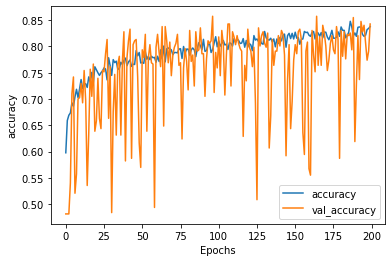

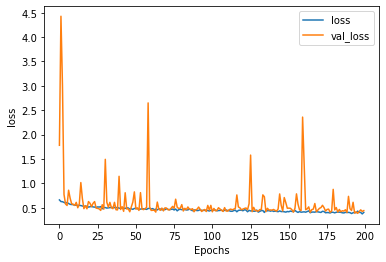

In [21]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
shutil.rmtree('/tmp/Liver')

In [ ]:
import os, signal
train_generator, test_generator
os.kill(os.getpid(),signal.SIGKILL)